## Lab 3: Subplot Visualization Help

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
%matplotlib inline

### Babynames Dataset

In [3]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a URL and return the file object.
    
    data_url: The web address to download.
    file: The file in which to save the results.
    data_dir: (default="data") The location to save the data.
    force: If true, the file is always re-downloaded. 
    
    return: The pathlib.Path to the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time 
        created = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded at", created)
    return file_path

In [4]:
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'
namesbystate_path = fetch_and_cache(data_url, 'namesbystate.zip')

Using cached version downloaded at Thu Jan 25 11:42:21 2024


In [5]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')

column_labels = ['State', 'Sex', 'Year', 'Name', 'Count']

def load_dataframe_from_zip(zf, f):
    with zf.open(f) as fh: 
        return pd.read_csv(fh, header=None, names=column_labels)

states = [
    load_dataframe_from_zip(zf, f)
    for f in sorted(zf.filelist, key=lambda x:x.filename) 
    if f.filename.endswith('.TXT')
]

babynames = states[0]
for state_df in states[1:]:
    babynames = pd.concat([babynames, state_df])
babynames = babynames.reset_index().iloc[:, 1:]

In [10]:
babynames.head()

,State,Sex,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


This is the same baby names dataset we worked with last week. Our goal will be to compare the popularity of the three most popular names over time, using the same subplot visualization setup needed for HW 1.

The `.value_counts()` method is one of the most useful Pandas methods included in the library, very practical for a case like this where we want to quickly find the the most common names in the dataset.

In [13]:
 babynames['Name'].value_counts()

James        7465
Leslie       7428
Lee          7344
John         7271
Robert       7225
             ... 
Elona           1
Jamill          1
Ekamveer        1
Yarisbeth       1
Zondra          1
Name: Name, Length: 32722, dtype: int64

We can see that 'James' is the most common name. We can create a new dataframe for just 'James' entries using the dataframe indexing methods we went over last week.

In [15]:
James = babynames[babynames['Name'] == 'James']
James

,State,Sex,Year,Name,Count
15340,AK,M,1910,James,7
15348,AK,M,1911,James,8
15358,AK,M,1912,James,5
15362,AK,M,1913,James,8
15365,AK,M,1914,James,12
...,...,...,...,...,...
6407417,WY,M,2018,James,13
6407535,WY,M,2019,James,20
6407683,WY,M,2020,James,15
6407801,WY,M,2021,James,21


This by itself doesn't get us very far. What we want is add up all the values in the `Count` column for every unique entry in the `Year` column, regardless of `State` or `Sex` values. It's entirely possible to do this by continuously applying the same indexing methods we used above, but a much more direct approach is to use the `.groubpy()` [method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

In [90]:
James = James.groupby(["Year"])[["Count"]].agg(sum).reset_index()
James

,Year,Count
0,1910,9202.0
1,1911,9981.0
2,1912,17683.0
3,1913,20881.0
4,1914,26326.0
...,...,...
108,2018,13641.0
109,2019,13198.0
110,2020,12390.0
111,2021,12452.0


In the previous cell, we are grouping the data based on `Year`, and aggregating by summing the numerical values in `Count` for each `Year`.

`.groubpy()` is a super useful function for transforming your dataframe based on categories, but it also has extremely confusing documentation that makes it difficult to use at it's fullest potential. That being said, 9/10 times you find yourself asking, 'How do I do _ in pandas?', the answer is probably `.groubpy()`


In [95]:
Leslie = babynames[babynames['Name'] == 'Leslie'].groupby(["Year"])[["Count"]].agg(sum).reset_index()
Lee = babynames[babynames['Name'] == 'Lee'].groupby(["Year"])[["Count"]].agg(sum).reset_index()

Our goal is to compare popularity of these names over time; in short plotting the count (y-axis) vs the year (x-axis) on some kind of linear plot. A basic example for one name might look like the following

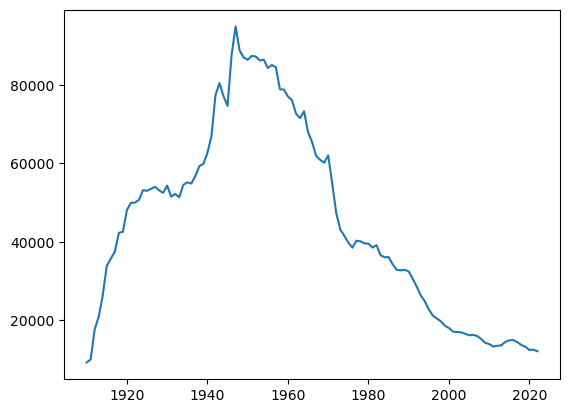

In [96]:
plt.plot(James['Year'],James['Count'])

A more complicated case would be the goal of HW 1, which involves subplots, insets, and a host of other attributes that make reproduction a challenge. Here, we will try to explore the basics of some of these complicated plotting techniques.

### Subplots

Examples of subplots can be found in the Lab2_Visualization notebook, as well as the matplotlib  [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html). Apart from giving actual documentation on the code, also included are numerous working examples towards the bottom of the page.

Below is the most basic example of subplot usage. Fortunately, the default behavior of matplotlib's subplot functions is to support vertically stacked plots like the one seen in HW 1, so not much needs to be changed.

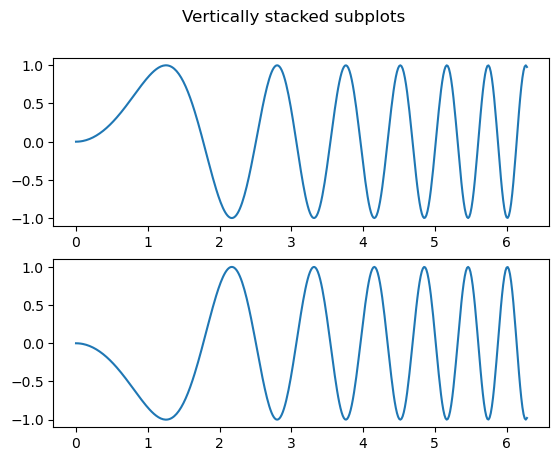

In [97]:
### Basic Example
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)


fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y)
axs[1].plot(x, -y)


Pretty straightforward, but still missing a few elements that we need to reproduce the figure in HW 1. Let's add:

1) An extra line to one of our subplots
2) Subplot axis labels
3) Random text

Text(0.5, -0.5, 'Random text')

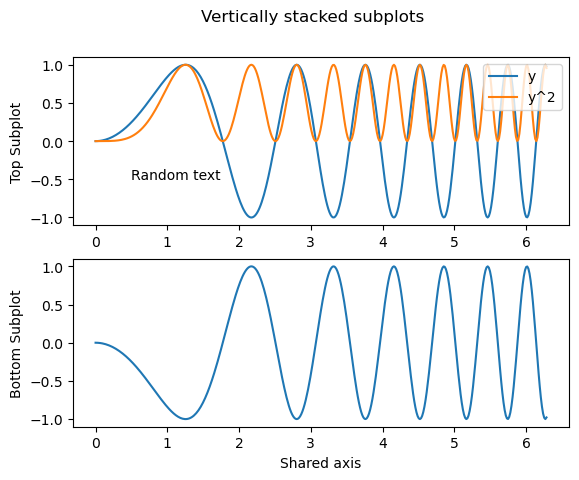

In [98]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

###########################
y_squared = y**2
###########################

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y,label='y')
axs[1].plot(x, -y)


###########################
axs[0].plot(x, y_squared,label='y^2')
axs[0].legend(loc='upper right')

axs[0].set(ylabel='Top Subplot')
axs[1].set(ylabel='Bottom Subplot')

axs[1].set(xlabel='Shared axis')

axs[0].text(0.5, -0.5, 'Random text')
###########################

A few notes:
- the syntax for axes labels is slightly different for axis objects compared to to figure objects (  plt.ylabel('label')  )
- the first two entries in the .text method specify the text location. I dont have good advice here, you'll need to play around with the numbers until the text is in the spot you want
- for vertically stacked subplots, the idea is that all plots share the same x-axis values, so we only need to apply that label to the bottom plot in order to give context to all subplots

# Excercise 1

Using the three name dataframes created earlier, construct a figure with stacked subplots for each name, including proper axis labels (with 'Year' as the shared x-axis).

In [99]:
...

Ellipsis

### Insets

There are multiple different ways of adding small insets to figures, all of which become significantly complicated when subplots are involved. I encourage you to look through some examples either in the matplotlib documentation or elsewhere online, but I'm going to provide a direct example here that should match what you need for HW 1.

Text(0.5, 0, 'inset x-axis')

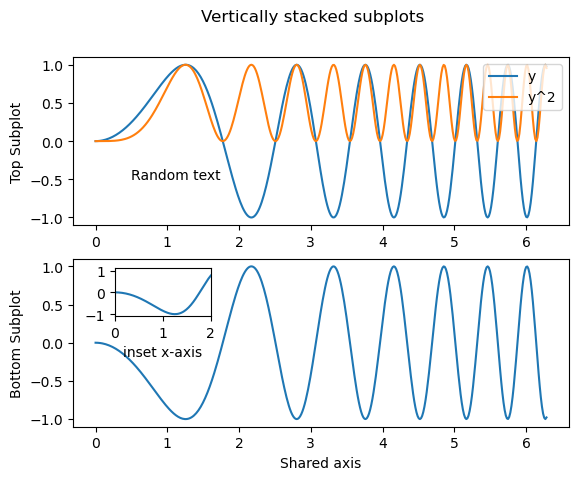

In [88]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
y_squared = y**2

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y,label='y')
axs[1].plot(x, -y)



axs[0].plot(x, y_squared,label='y^2')
axs[0].legend(loc='upper right')
axs[0].set(ylabel='Top Subplot')
axs[1].set(ylabel='Bottom Subplot')
axs[1].set(xlabel='Shared axis')
axs[0].text(0.5, -0.5, 'Random text')




###########################
# bottom subplot inset
left, bottom, width, height = [0.19, 0.34, 0.15, 0.1]
axin = fig.add_axes([left, bottom, width, height])
axin.plot(x, -y)
axin.set_xlim(0,2)
axin.set_xticks([0,1,2])

axin.set_xlabel(r'inset x-axis')
###########################





# Excercise 2

Modify your plot from  Excercise 1 to include an inset showing a 10 year windowed centered at the year of peak popularity for the name 'James'

### Misc notes




#### LaTeX
Matplotlib support LaTeX formatting for including symbols or 'math' notation in the titles, axes labels, and legends. You can format your text this way by doing `'$math text$'`

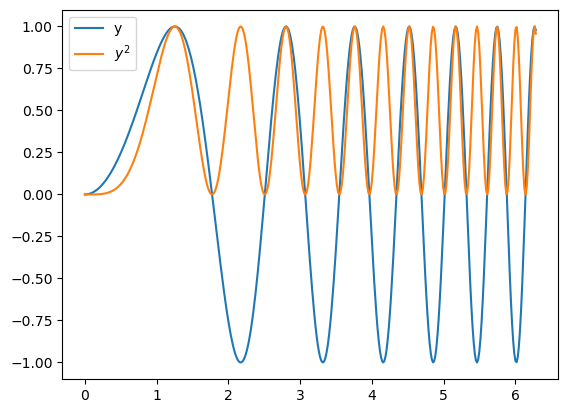

In [105]:
plt.plot(x,y,label='y')
plt.plot(x,y_squared,label = '$y^2$') ### note how this changes the y^2 to actual be an exponent
plt.legend()

For more complicated 'math' expressions you will need a basic understanding of LaTeX formatting. Plenty of resources can be found online, such as this [cheat sheet](https://ashki23.github.io/markdown-latex.html)

#### Line formatting

Matplotlib will by default always use the same color scheme based on the order .plot() was called with multiple plots. You can see the sequential list of colors [here](https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html#colors-in-default-property-cycle) along with their corresponding Hexadecimal keys. The defaul line style is what you've seen so far, but the syntax for creating dashed or dotted lines is given in the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) (CTRL+F line style)

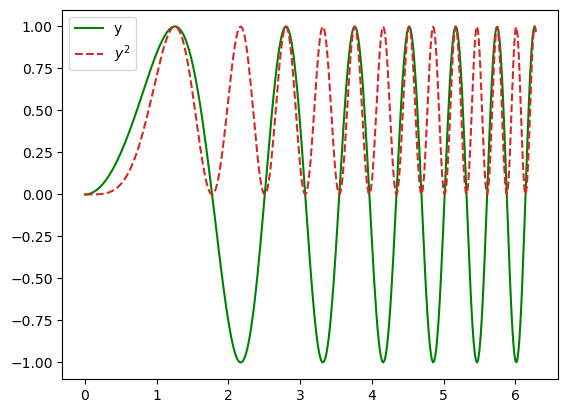

In [111]:
plt.plot(x,y,label='y',c='green') ### can use color labels ('green' or 'g')
plt.plot(x,y_squared,'--',label = '$y^2$',c='#d62728') ### can also use hexadecimal keys for specific colors

# need to place '--' right after x,y entries in .plot() otherwise you get an error
plt.legend()